# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [121]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 7

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [122]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [123]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full.numpy(), y_full.numpy(),
    test_size=0.3,
    random_state=GROUP_NUMBER
)

# Convert back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(f"\nTraining Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")


Training Set: torch.Size([2100, 2])
Validation Set: torch.Size([900, 2])


In [124]:
class ManualMLP:
    """
    Multi-Layer Perceptron with 3 hidden layers (16 neurons each).
    Architecture: 2 -> 16 -> 16 -> 16 -> 1
    """
    def __init__(self, input_size=2, hidden_size=16, output_size=1):
        # Improved initialization with proper scaling
        std1 = np.sqrt(2.0 / input_size)
        self.w1 = torch.randn(input_size, hidden_size, dtype=torch.float32) * std1
        self.w1.requires_grad = True
        self.b1 = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)

        std2 = np.sqrt(2.0 / hidden_size)
        self.w2 = torch.randn(hidden_size, hidden_size, dtype=torch.float32) * std2
        self.w2.requires_grad = True
        self.b2 = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)

        std3 = np.sqrt(2.0 / hidden_size)
        self.w3 = torch.randn(hidden_size, hidden_size, dtype=torch.float32) * std3
        self.w3.requires_grad = True
        self.b3 = torch.zeros(hidden_size, dtype=torch.float32, requires_grad=True)

        std4 = np.sqrt(2.0 / hidden_size)
        self.w4 = torch.randn(hidden_size, output_size, dtype=torch.float32) * std4
        self.w4.requires_grad = True
        self.b4 = torch.zeros(output_size, dtype=torch.float32, requires_grad=True)

        self.params = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3, self.w4, self.b4]

    def sigmoid(self, x):
        """Sigmoid activation function with numerical stability"""
        return torch.sigmoid(x)

    def relu(self, x):
        """ReLU activation function"""
        return torch.relu(x)

    def forward(self, x):
        """Forward pass through the network"""
        # Layer 1
        z1 = torch.matmul(x, self.w1) + self.b1
        a1 = self.relu(z1)

        # Layer 2
        z2 = torch.matmul(a1, self.w2) + self.b2
        a2 = self.relu(z2)

        # Layer 3
        z3 = torch.matmul(a2, self.w3) + self.b3
        a3 = self.relu(z3)

        # Output Layer
        z4 = torch.matmul(a3, self.w4) + self.b4
        output = self.sigmoid(z4)

        return output

    def zero_grad(self):
        """Zero out gradients for all parameters"""
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [125]:
def binary_cross_entropy(y_pred, y_true):
    """
    Manual Binary Cross Entropy Loss
    Loss = -1/N * sum[y*log(y_pred) + (1-y)*log(1-y_pred)]
    """
    # Clamp predictions to avoid log(0)
    y_pred_clamped = torch.clamp(y_pred, min=1e-7, max=1-1e-7)

    loss = -torch.mean(
        y_true * torch.log(y_pred_clamped) + (1 - y_true) * torch.log(1 - y_pred_clamped)
    )
    return loss


In [126]:
def train_model(model, X_train, y_train, X_val, y_val,
                epochs=1000, learning_rate=0.02):
    """
    Training loop with manual SGD optimization
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Forward pass (Training)
        y_pred_train = model.forward(X_train)
        train_loss = binary_cross_entropy(y_pred_train, y_train)

        # Backward pass
        model.zero_grad()
        train_loss.backward()

        # Manual weight update (Gradient Descent)
        with torch.no_grad():
            for param in model.params:
                if param.grad is not None:
                    param -= learning_rate * param.grad

        # Calculate training accuracy
        train_predictions = (y_pred_train > 0.5).float()
        train_acc = (train_predictions == y_train).float().mean()

        # Validation (No gradient computation)
        with torch.no_grad():
            y_pred_val = model.forward(X_val)
            val_loss = binary_cross_entropy(y_pred_val, y_val)
            val_predictions = (y_pred_val > 0.5).float()
            val_acc = (val_predictions == y_val).float().mean()

        # Store metrics
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accs.append(train_acc.item())
        val_accs.append(val_acc.item())

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss.item():.4f} | "
                  f"Val Loss: {val_loss.item():.4f} | "
                  f"Train Acc: {train_acc.item():.4f} | "
                  f"Val Acc: {val_acc.item():.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [127]:
# Initialize and train the model
model = ManualMLP(input_size=2, hidden_size=16, output_size=1)

print("\nTRAINING COMMENCED...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, X_train, y_train, X_val, y_val,
    epochs=1000, learning_rate=0.3
)


TRAINING COMMENCED...
Epoch 100/1000 | Train Loss: 0.6011 | Val Loss: 0.6211 | Train Acc: 0.5881 | Val Acc: 0.5611
Epoch 200/1000 | Train Loss: 0.5909 | Val Loss: 0.6131 | Train Acc: 0.6633 | Val Acc: 0.5567
Epoch 300/1000 | Train Loss: 0.5865 | Val Loss: 0.6127 | Train Acc: 0.7129 | Val Acc: 0.5556
Epoch 400/1000 | Train Loss: 0.5452 | Val Loss: 0.5724 | Train Acc: 0.7700 | Val Acc: 0.6444
Epoch 500/1000 | Train Loss: 0.4360 | Val Loss: 0.4696 | Train Acc: 0.8290 | Val Acc: 0.7722
Epoch 600/1000 | Train Loss: 0.3821 | Val Loss: 0.4191 | Train Acc: 0.8400 | Val Acc: 0.8156
Epoch 700/1000 | Train Loss: 0.3435 | Val Loss: 0.3853 | Train Acc: 0.8629 | Val Acc: 0.8467
Epoch 800/1000 | Train Loss: 0.3113 | Val Loss: 0.3498 | Train Acc: 0.8867 | Val Acc: 0.8778
Epoch 900/1000 | Train Loss: 0.3023 | Val Loss: 0.3387 | Train Acc: 0.8929 | Val Acc: 0.8889
Epoch 1000/1000 | Train Loss: 0.2944 | Val Loss: 0.3322 | Train Acc: 0.8976 | Val Acc: 0.8900


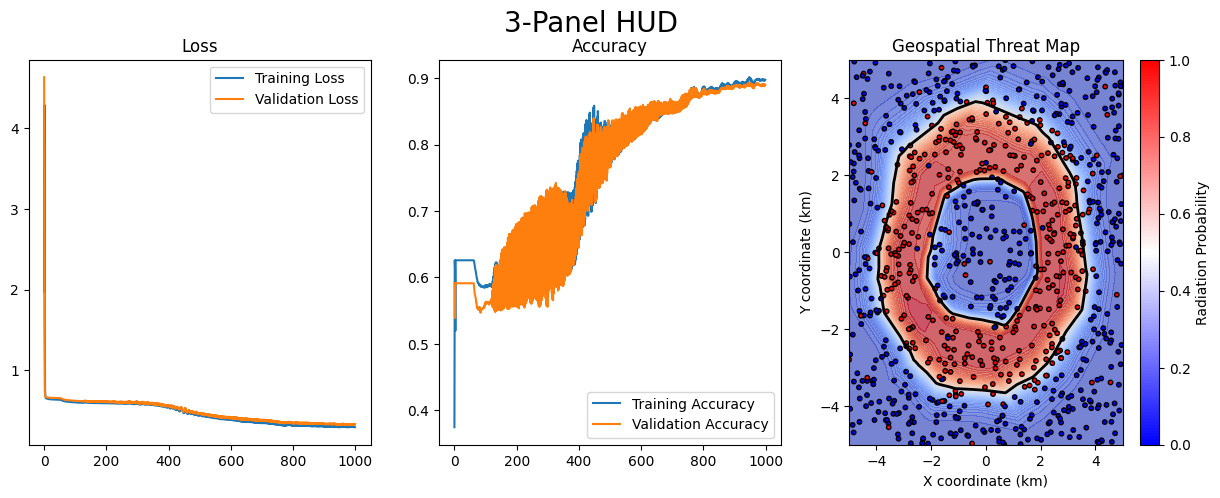

In [128]:
# Display
plt.figure(figsize = (15,5))

# System Error Trajectory (Loss Plot)
plt.subplot(1,3,1)
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.title("Loss")
plt.legend()

# Integrity Check (Accuracy Plot)
plt.subplot(1,3,2)
plt.plot(train_accs, label = "Training Accuracy")
plt.plot(val_accs, label = "Validation Accuracy")
plt.title("Accuracy")
plt.legend()

# Geospatial Threat Map (Decision Boundary)
plt.subplot(1,3,3)
# Finding min. & max. distance from our dataset
x_min, x_max = X_full[:, 0].min(), X_full[:, 0].max()
y_min, y_max = X_full[:, 1].min(), X_full[:, 1].max()
# Grid to cover the entire 2D map
x, y = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
grid = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype = torch.float32)
# Getting prediction over grid
with torch.no_grad():
    probs = model.forward(grid).reshape(x.shape)
# Probability Heatmap
plt.contourf(x, y, probs, levels = 50, cmap = "coolwarm", alpha = 0.7)
# Decision boundary at probability = 0.5
plt.contour(x, y, probs, levels = [0.5], colors = "black", linewidths = 2)
# Validation points
plt.scatter(X_val[:, 0], X_val[:, 1], c = y_val[:,0], cmap = "bwr", edgecolors = "k", s = 10)
plt.xlabel("X coordinate (km)")
plt.ylabel("Y coordinate (km)")
plt.title("Geospatial Threat Map")
plt.colorbar(label="Radiation Probability") # Color bar for Radiation Probability

plt.suptitle("3-Panel HUD", fontsize = 20)
plt.show()

In [ ]:
print(f"Group Number: {GROUP_NUMBER}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")

Group Number: 7
Final Training Loss: 0.2944
Final Validation Loss: 0.3322
Final Training Accuracy: 89.76%
Final Validation Accuracy: 89.00%
